In [91]:
from utils import *
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [47]:
modular_graph = create_adjacency_matrix_for_modular_graph(15, 3, [5, 5, 5], [(0, 14), (4, 5), (9, 10)], [0, 4, 5, 9, 10, 14])
walk = random_hop(modular_graph, 1000, 1000).astype(int)

In [96]:
beta = 0.01
alpha = 0.2
def simulate_tcm_encoder(alpha, beta, walk_length, num_trials):
    walk = random_hop(modular_graph, walk_length, num_trials).astype(int)
    items = np.identity(15)
    context = np.random.uniform(0, 1, (15, 15))
    presented_items = items[walk]
    m_fc = np.random.uniform(0, 1, (15, 15))
    
    for i in range(1, walk_length):
        c_IN = np.dot(m_fc, presented_items[i])
        c_IN = c_IN/np.linalg.norm(c_IN)
        rho = np.sqrt(1+(beta**2)*((np.dot(context[walk[i-1]] , c_IN)**2)-1)) - beta*np.dot(context[walk[i-1]],c_IN);
        context[walk[i]] = rho*context[walk[i-1]] + beta*c_IN
        m_fc[walk[i]] = m_fc[walk[i]] + alpha*np.dot(presented_items[walk[i]], context[walk[i-1]])
    return m_fc

In [97]:
def compute_entropy(context_matrix):
    node_entropy = np.zeros(context_matrix.shape[0])
    for node in range(context_matrix.shape[0]):
        node_entropy[node] = -np.sum(context[node]*np.log(context_matrix[node]))
    return node_entropy

In [98]:
def compute_entropy_diff(node_entropies, boundary_nodes):
    boundary_entropy = np.mean(node_entropies[boundary_nodes])
    nonboundary_entropy = np.mean(np.delete(node_entropies, boundary_nodes))
    return boundary_entropy-nonboundary_entropy

In [100]:
context_matrix = simulate_tcm_encoder(0.2, 0.01, 1000, 1000)
node_entropy = compute_entropy(context_matrix)
boundary_diff = compute_entropy_diff(node_entropy, np.array([0, 4, 5, 9, 10, 14]))

In [125]:
alpha = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
beta = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
walk_length = [1, 2, 3, 4, 5, 1000]
num_trials = [1000]
params = itertools.product(alpha, beta, walk_length, num_trials)

In [126]:
def sim_tcm_boundary_entropy(params):
    context_matrix = simulate_tcm_encoder(params[0], params[1], params[2], params[3])
    node_entropy = compute_entropy(context_matrix)
    boundary_diff = compute_entropy_diff(node_entropy, np.array([0, 4, 5, 9, 10, 14]))
    return boundary_diff


In [127]:
boundary_diff = np.array([sim_tcm_boundary_entropy(param) for param in params])

In [128]:
boundary_diff_df = pd.DataFrame({'alpha': np.repeat(alpha, len(beta)*len(walk_length)),
                                 'beta': np.tile(np.repeat(beta, len(walk_length)), len(alpha)),
                                 'walk_length': np.tile(walk_length, len(alpha)*len(beta)),
                                 'boundary_diff': boundary_diff
                                 })

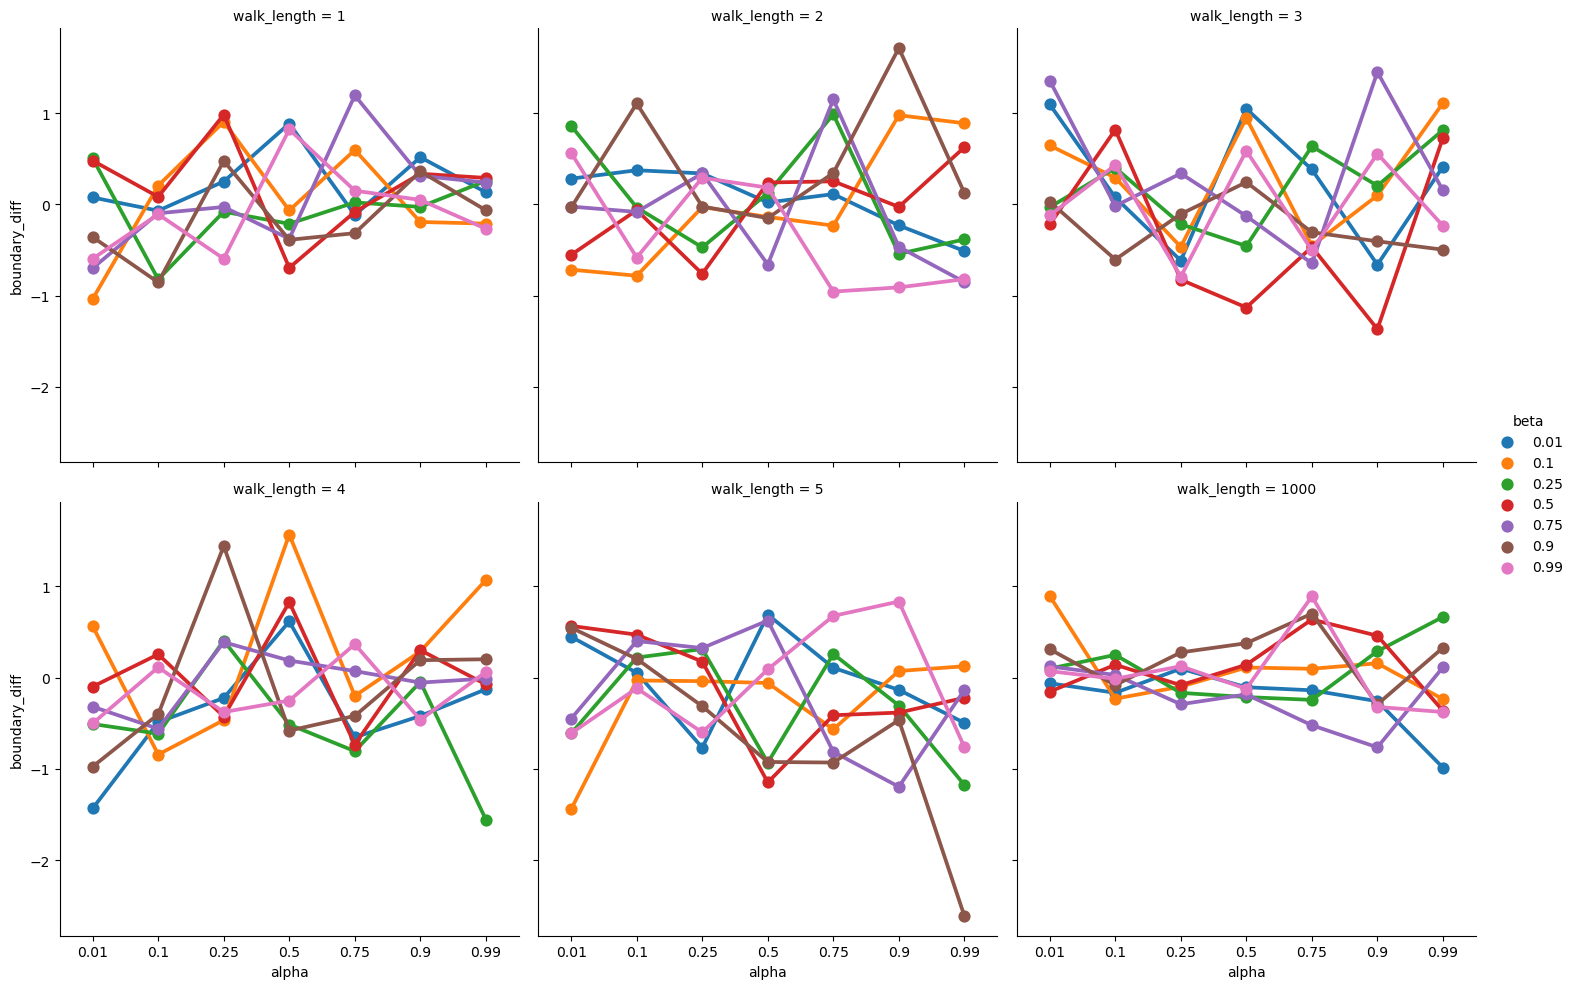

In [129]:
sns.catplot(x = 'alpha', y = 'boundary_diff', hue = 'beta', data = boundary_diff_df, col = 'walk_length', 
            col_wrap = 3, kind = 'point')